# Validation of the classification based on the WFsim #

2019/09/28

Authors:
 - Clark, Michael <clark632@purdue.edu>
 - Angevaare, Joran <j.angevaare@nikhef.nl>
 
**Updates:**

2019/11/14

## This notebook #
Buggs in the WFsim that are important to keep in mind:
 -  <s>There is no double photo-emission taken into account
 -  There may be only ~ 500 events before the WFsim crashes<s>
 
 
Possible extensions:
 - Add afterpulse boolian to the 'truth' info
 - Do the same for the other detector types

In [1]:
import strax
import straxen

Joran is awesome


In [2]:
import wfsim

We include ``recarray_tools.py`` here that is used to add columns and do things with structured arrays. 
Taken from:

    https://github.com/XENON1T/XeAnalysisScripts/tree/master/PeakFinderTest

In [3]:
from peak_classification.peak_finder import *

In [4]:
from peak_classification.wfsim_utils import *

Initize the wavefrom simulator

In [5]:
c = dict(event_rate = 50, chunk_size=1, nchunk=1)
inst = rand_instructions(c)
pd.DataFrame(inst).to_csv('test_uni.csv', index=False)

In [6]:
st = strax.Context(
register=[wfsim.RawRecordsFromFax],
config=dict(fax_file='./test_uni.csv'),
**straxen.contexts.common_opts)

In [7]:
# Just some id from post-SR1, so the corrections work
run_id = '180519_1902'

In [8]:
!rm -r strax_data
peaks = st.make(run_id, 'peak_basics')

Simulating Raw Records: 100%|██████████| 100/100 [00:16<00:00,  5.88it/s]


Source finished!


In [9]:
truth = st.get_array(run_id, 'truth')
data = st.get_array(run_id, ['peak_basics','peak_classification'])

This is to compensate for the fact that we dont have event numbers (Binning in time to group peaks)

In [10]:
n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
c['total_time'] = c['chunk_size'] * c['nchunk']
timing_grid = np.linspace(0, c['total_time'], n+1) * 1e9

In [11]:
### Proxy for event number

truth = append_fields(truth, 'merge_index',np.digitize(truth['t'], timing_grid))
data = append_fields(data, 'merge_index',np.digitize(data['time'], timing_grid))

In [12]:
### Proxy for area of truth peak

truth = append_fields(truth, 'area', truth['n_photon'])

**There is a bug that the types are listed here as strings, where in strax they are integers**
The code here is to change that such that we can compare them directly

In [13]:
###!! 
###!! 
###!!
###!!

truth = append_fields(truth, 'typeint',np.ones(len(truth)), dtypes=np.int)
# truth['typeint'][truth['type'] == 's2'] = np.int(2)
# truth['typeint'][truth['type'] == 's1'] = np.int(1)
data = append_fields(data, 'typeint',data['type'], dtypes=np.int)


Proxy for ``left`` and ``right`` (as in ``PAX``) sides of peak in truth.

In [14]:
### Proxy for left and right of peak
truth = append_fields(truth, 
                      ('time','endtime'), 
                      (truth['t_first_photon'],
                       truth['t_last_photon']))

##3 Will need to add check to see if last electron is after last photon as below
#
#truth['endtime'] = truth['t_last_photon']
#mask = truth['endtime'] < truth['t_last_electron']
#truth['endtime'][mask] = truth['t_last_electron'][mask]

**We think there is a bug that makes all the peak times 500 ns earlier than the truth values**

We change the data here to move all times by 500 ns

In [15]:
###!!
###!!
###!! 
# data['time'] = data['time']+500
# data['endtime'] = data['endtime']+500

Here in match_peaks.py, written by Jelle, to compare two sets of peaks

Changes:
  -  Changed 'type' to 'typeint' because types are listed as integers in strax

Call with (truth, data)

In [16]:
truthmatched, datamatched = match_peaks(truth,data)

Matching peaks: 100%|██████████| 50/50 [00:00<00:00, 6494.74it/s]

	Appending extra fields...

	Grouping peaks 1 by event...

	Grouping peaks 2 by event...



Below is the output of match_peaks for the truth data.  
  - For each peak, **outcome** shows whether the peak was found, missed, merged, split up, or misidentified in the output of strax for the simulated data
  - **matched_to** shows which peak (peak_id in the other array) it was matched with, or the biggest peak it was matched with 

<img src='toptruthmatches.png'>
  
Below is the corresponding match_index in the simulated data
<img src='topdatamatch.png'>
  
You can see the splitting of the true s2 into an s1 and an s2

In [17]:
pd.DataFrame.from_records(truthmatched[['merge_index','type','time','area','endtime','matched_to','outcome']])


,merge_index,type,time,area,endtime,matched_to,outcome
0,1,1,1.000002e+07,145.0,1.000020e+07,0,b'found'
1,1,2,1.020545e+07,3596.0,1.021148e+07,1,b'misid_as_s2'
2,2,1,3.000002e+07,89.0,3.000024e+07,5,b'found'
3,2,2,3.070795e+07,45943.0,3.071960e+07,6,b'misid_as_s2'
4,3,1,5.000002e+07,207.0,5.000022e+07,22,b'found'
...,...,...,...,...,...,...,...
95,48,2,9.500741e+08,2510.0,9.500770e+08,252,b'misid_as_s2'
96,49,1,9.700000e+08,234.0,9.700002e+08,255,b'found'
97,49,2,9.703657e+08,2334.0,9.703731e+08,256,b'misid_as_s2'
98,50,1,9.900000e+08,83.0,9.900001e+08,258,b'found'


In [18]:
pd.DataFrame.from_records(datamatched[['merge_index','type','time','area','endtime','matched_to','outcome']]).head(20)
#pd.DataFrame.from_records(truthmatched[['merge_index','type','time','area','endtime','matched_to','outcome']])


,merge_index,type,time,area,endtime,matched_to,outcome
0,1,1,10000000,178.184692,10000320,0,b'found'
1,1,2,10205430,4002.647217,10211670,1,b'misid_as_s1'
2,1,0,10212100,1.214723,10212430,-99999,b'missed'
3,1,1,10226910,23.264921,10227540,-99999,b'missed'
4,1,2,10331030,13.865091,10331650,-99999,b'missed'
5,2,1,30000000,95.880775,30000300,2,b'found'
6,2,2,30707930,50973.152344,30719630,3,b'misid_as_s1'
7,2,2,30744130,33.173477,30744740,-99999,b'missed'
8,2,2,30750310,22.980637,30750890,-99999,b'missed'
9,2,0,30765580,29.926323,30766210,-99999,b'missed'


In [19]:
pd.DataFrame.from_records(truthmatched[truthmatched['outcome'] == b'found'][['merge_index','type','time','area','endtime','matched_to','outcome']])

,merge_index,type,time,area,endtime,matched_to,outcome
0,1,1,1.000002e+07,145.0,1.000020e+07,0,b'found'
1,2,1,3.000002e+07,89.0,3.000024e+07,5,b'found'
2,3,1,5.000002e+07,207.0,5.000022e+07,22,b'found'
3,4,1,7.000002e+07,59.0,7.000011e+07,32,b'found'
4,5,1,9.000003e+07,75.0,9.000013e+07,39,b'found'
5,6,1,1.100000e+08,157.0,1.100002e+08,43,b'found'
6,7,1,1.300000e+08,154.0,1.300002e+08,45,b'found'
7,8,1,1.500000e+08,39.0,1.500001e+08,48,b'found'
8,9,1,1.700000e+08,125.0,1.700002e+08,54,b'found'
9,10,1,1.900000e+08,189.0,1.900003e+08,61,b'found'


## Plotting the results ##
The plots below show the fraction of several of the ``dtypes`` of the ``truth`` or the ``data``. These fractions show how many of the ``peaks`` were found correctly.

	50.00% b'found'


/home/angevaare/software/workshop_lngs_sept19/projects/peak_classification_validation_Mike_Joran/peak_classification/peak_finder.py:379: RuntimeWarning: invalid value encountered in true_divide
  hist /= n_peaks_hist.histogram.astype('float')


	37.00% b'misid_as_s2'
	13.00% b'split_and_misid'


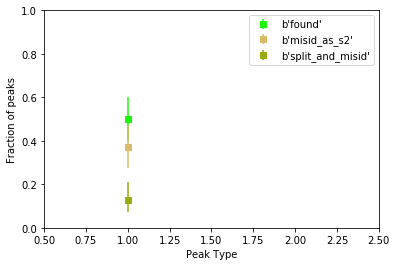

In [20]:
plot_peak_matching_histogram(truthmatched,'typeint',bins=[0.5,1.5,2.5])
plt.xlabel('Peak Type')
plt.show()

	18.05% b'found'
	0.36% b'merged'
	10.47% b'merged_to_s1'
	13.36% b'misid_as_s1'
	57.76% b'missed'


Text(0.5, 0, 'Peak Type')

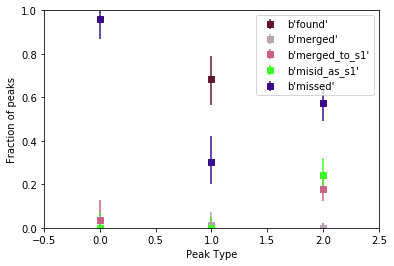

In [21]:
plot_peak_matching_histogram(datamatched,'typeint',bins= [-0.5,0.5,1.5,2.5])
plt.xlabel('Peak Type')

	50.00% b'found'
	37.00% b'misid_as_s2'
	13.00% b'split_and_misid'


Text(0.5, 0, 'Depth')

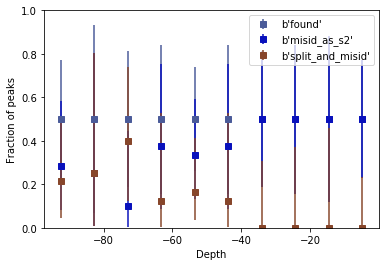

In [22]:
plot_peak_matching_histogram(truthmatched,'z')
plt.xlabel('Depth')

	18.05% b'found'
	0.36% b'merged'
	10.47% b'merged_to_s1'
	13.36% b'misid_as_s1'
	57.76% b'missed'


Text(0.5, 0, 'Area Fraction Top')

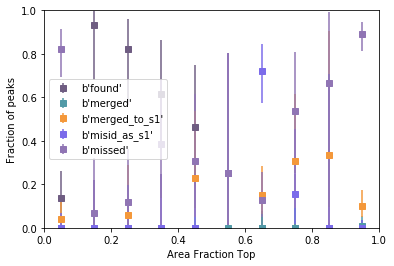

In [23]:
plot_peak_matching_histogram(datamatched,'area_fraction_top')
plt.xlabel('Area Fraction Top')